In [1]:
from transformers import XLNetModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
import pandas as pd
import numpy as np

from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch import optim


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

RANDOM_SEED = 20
NUMBER_LABELS = 5 
NUMBER_FEATURES = 9
MODEL = 'charlieoneill/distilbert-base-uncased-finetuned-tweet_eval-offensive'
tokenizer = XLNetTokenizer.from_pretrained(MODEL)

BATCH_SIZE = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)
torch.cuda.empty_cache()

# Load data

In [4]:
df =  pd.read_csv("../../data/data_old_v2/processed_data_Q"+str(Q_NO)+".csv").drop(['plagiarized_score', 'plagiarized_index'],axis=1)

df = df[~df['ID'].isin(IDS)]

# transform label
df[VAR_S] = df[VAR_S]-1
df[VAR_S].value_counts()

scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(df.loc[:,'length_in_words':]))
df = pd.concat([df.loc[:,['ID',VAR_Q,VAR_S]], features], axis=1)

# define the downsampling condition
condition =  f'{VAR_S} == 1 |  {VAR_S} == 2'

# filter the dataframe based on the condition
downsampled_df = df.query(condition)

# randomly select a subset of rows to keep
frac_to_keep = 0.5  # fraction of rows to keep
downsampled_df = downsampled_df.sample(frac=frac_to_keep)

df = df.query(f'{VAR_S} != 1 & {VAR_S} != 2')

df = pd.concat([df,downsampled_df],axis=0)

In [5]:
df_train_val, df_test = train_test_split(df, test_size=0.15,random_state=RANDOM_SEED)
df_train, df_val = train_test_split(df_train_val,test_size=0.2,random_state=RANDOM_SEED)

df_train = df_train.dropna()
df_val = df_val[df_val['ID']!=1].dropna()
df_test = df_test[df_test['ID']!=1].dropna()

In [6]:
print(len(df_train))
print(len(df_val))
print(len(df_test))

1097
248
219


# Create a pytorch dataset class and dataloader

In [7]:
class LFG_dataset(Dataset):

  def __init__(self,tokenizer, max_len, answers, scores, features):
    self.tokenizer = tokenizer
    self.max_len = max_len

    # answer and scores
    self.answers = answers
    self.scores = scores

    self.features = features
  
  def __len__(self):
    return len(self.answers)
  
  def __getitem__(self, idx):
    answer = self.answers[idx]
    score = self.scores[idx]
    features = self.features[idx]
   
    encoding = tokenizer(
      answer,
      max_length = self.max_len,
      padding ='max_length',
      truncation = True,
      return_tensors='pt',
    )

    
    return {
      'answer_text': answer,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'score' : torch.tensor(score, dtype=torch.long),
      'features': torch.tensor(features,dtype=torch.float32)
    }

In [8]:
def create_data_loader(df, tokenizer, max_len, batch_size=1):
  ds = LFG_dataset(
    tokenizer=tokenizer,
    max_len=max_len,
    answers=df[VAR_Q].to_numpy(),
    scores=df[VAR_S].to_numpy().astype(int),
    features= df.iloc[:,2:].to_numpy().astype(float)
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [9]:
train_data_loader = create_data_loader(df_train.drop(columns=['ID']), tokenizer, 550, BATCH_SIZE)
val_data_loader = create_data_loader(df_val.drop(columns=['ID']), tokenizer, 550, BATCH_SIZE)
test_data_loader = create_data_loader(df_test.drop(columns=['ID']), tokenizer, 550)

In [10]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df_train[VAR_S]), y=df_train[VAR_S])
class_weights=torch.tensor(class_weights,dtype=torch.float)

# Model and loss function

In [11]:
class LFG_grading(nn.Module):

    def __init__(self, n_classes, n_features):
        super(LFG_grading, self).__init__()
        self.xlnet = XLNetModel.from_pretrained(MODEL)

        self.drop = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear((self.xlnet.config.hidden_size + n_features), 350)
        self.fc2 = nn.Linear(350,350)
        self.fc3 = nn.Linear(350,n_classes)
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
  
    def forward(self, input_ids, attention_mask, features):
        output = self.xlnet(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        # Get the first element of output which is the hidden state
        # Get the embeddings of CLS token
        cls_embeddings = output[0][:,-1,:]
        
        # Add features along with cls embeddings
        output = torch.concat([cls_embeddings,features], dim=1)

        # Layer 1
        output = self.drop(output)
        output = self.fc1(output)
        output = self.relu(output)
        
        # Layer 2
        output = self.drop(output)
        output = self.fc2(output)
        output = self.relu(output)
        
        #Layer 3
        output = self.drop(output)
        output = self.fc3(output)
        return self.softmax(output)

    def requires_grad_embeddings(self, val):
        for param in self.xlnet.parameters():
            param.requires_grad = val   
  

In [12]:
# Save the model to a file
def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)
    print(f"Model saved to {file_path}")

# Load the model from a file
def load_model(model_class, n_classes,n_features, file_path):
    model = model_class(n_classes, n_features)
    model.load_state_dict(torch.load(file_path))
    model.eval()  # Set the model to evaluation mode
    print(f"Model loaded from {file_path}")
    return model

In [13]:
class OrdinalLoss(nn.Module):
    def __init__(self, weight):
        super(OrdinalLoss, self).__init__()
        self.weight = weight

    def forward(self, output, target):
        # Following https://github.com/JHart96/keras_ordinal_categorical_crossentropy

        # Take the weighted cross entropy loss 
        criterion = nn.CrossEntropyLoss(weight=self.weight, reduction='none').to(device)

        # Calculate term W 
        output_label = torch.argmax(output, dim=1)
        
        # 5 classes, divided by 4
        w = torch.abs(output_label-target)/4
        
        # Calculate loss 
        loss = (w+1)*criterion(output, target)
        return loss.mean(dim=0)

# Training loop

In [14]:
EPOCHS = 6

model = LFG_grading(NUMBER_LABELS,NUMBER_FEATURES).to(device)
model.requires_grad_embeddings(True)

optimizer = optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = OrdinalLoss(weight=class_weights).to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
def train_epoch(model, train_data_loader, n_train_examples, val_data_loader, n_val_examples, loss_fn, optimizer, device, scheduler):
  model = model.train()

  train_loss = []
  train_correct_predictions = 0
  
  for i,d in enumerate(tqdm(train_data_loader)):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["score"].to(device)
    features = d["features"].to(device)

    outputs = model(
      input_ids = input_ids,
      attention_mask = attention_mask,
      features = features
    )

    loss = loss_fn(outputs, targets)
    train_loss.append(loss.item())
    loss.backward()

    predictions = outputs.argmax(dim=1)
    train_correct_predictions += torch.sum(predictions == targets)

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    
  val_loss = []
  val_correct_predictions = 0

  with torch.no_grad():
    model.eval()
    for i, d in enumerate(tqdm(val_data_loader)):
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["score"].to(device)
      features = d["features"].to(device)

      outputs = model(
        input_ids = input_ids,
        attention_mask = attention_mask,
        features = features
      )

      loss = loss_fn(outputs, targets)
      val_loss.append(loss.item())

      predictions = outputs.argmax(dim=1)
      val_correct_predictions += torch.sum(predictions == targets)


  return (train_correct_predictions.double() / n_train_examples), np.mean(train_loss), (val_correct_predictions.double()/n_val_examples), np.mean(val_loss)

In [16]:
def test_epoch(model, data_loader, device):
    predictions = torch.tensor([], dtype=torch.long).to(device)
    targets = torch.tensor([], dtype=torch.long).to(device)

    model = model.eval()
    with torch.no_grad():
        for i,d in enumerate(tqdm(data_loader)):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            score = d["score"].to(device)
            features = d["features"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                features = features
            )

            predictions = torch.cat((predictions,outputs.argmax(dim=1)), dim=0)
            targets = torch.cat((targets,score), dim=0)
    return targets, predictions

In [17]:
train_acc_hist = []
val_acc_hist = []
train_loss_hist = []
val_loss_hist = []
for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss, val_acc, val_loss = train_epoch(
    model,
    train_data_loader,
    len(df_train),
    val_data_loader,
    len(df_val),
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
  )
  
  train_acc_hist.append(train_acc)
  train_loss_hist.append(train_loss)
  val_acc_hist.append(val_acc)
  val_loss_hist.append(val_loss)
  print(f'Train loss {train_loss} accuracy {train_acc}')
  print(f'Val loss   {val_loss} accuracy {val_acc}')
  print()

Epoch 1/6
----------


100%|██████████| 31/31 [00:28<00:00,  1.09it/s]


Train loss 2.1982398620550185 accuracy 0.23883318140382861
Val loss   1.7044369636043426 accuracy 0.3387096774193548

Epoch 2/6
----------


100%|██████████| 31/31 [00:28<00:00,  1.09it/s]


Train loss 2.0222580376742543 accuracy 0.3509571558796718
Val loss   1.676217863636632 accuracy 0.3387096774193548

Epoch 3/6
----------


100%|██████████| 31/31 [00:28<00:00,  1.09it/s]


Train loss 1.9262374086656433 accuracy 0.4038286235186873
Val loss   1.581080109842362 accuracy 0.41532258064516125

Epoch 4/6
----------


100%|██████████| 31/31 [00:28<00:00,  1.09it/s]


Train loss 1.8715272027513254 accuracy 0.43482224247948953
Val loss   1.5288078323487313 accuracy 0.4798387096774193

Epoch 5/6
----------


100%|██████████| 31/31 [00:28<00:00,  1.09it/s]


Train loss 1.8292563130026278 accuracy 0.4676390154968095
Val loss   1.534969441352352 accuracy 0.4959677419354839

Epoch 6/6
----------


100%|██████████| 31/31 [00:28<00:00,  1.09it/s]

Train loss 1.802896150212357 accuracy 0.49407474931631723
Val loss   1.5337850662969774 accuracy 0.49193548387096775



In [18]:
save_model(model,f"{NAME}.pth")

Model saved to Q6.pth


In [19]:
# model = load_model(LFG_grading,NUMBER_LABELS,NUMBER_FEATURES,f"{NAME_TO_SAVE}.pth")

100%|██████████| 219/219 [00:16<00:00, 13.06it/s]


F1 score 0.33796631790362197
Accuracy 0.4611872146118721


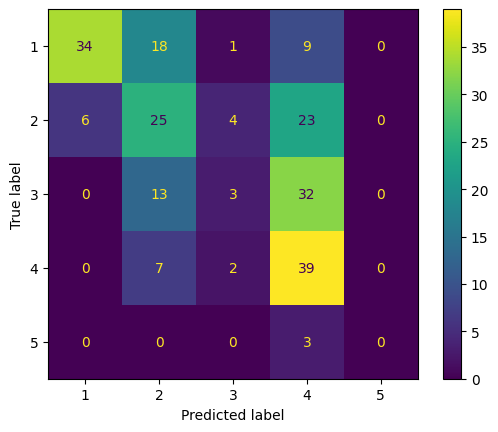

In [20]:
true, predict = test_epoch(model.to(device), test_data_loader, device)
true = true.to('cpu')
predict = predict.to('cpu')
cm=confusion_matrix(true, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
disp.plot()
disp.figure_.savefig(NAME)
print(f"F1 score {f1_score(true, predict, average='macro')}")
print(f"Accuracy {accuracy_score(true, predict)}")


Export result

In [21]:
export = df_test[['ID',VAR_S]]
export[f"predict_{VAR_Q}"] = predict
export.rename(columns={VAR_S : f'acutal_{VAR_Q}'})
export.to_csv(f"result_{NAME}.csv")

/tmp/ipykernel_1683/1220976931.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export[f"predict_{VAR_Q}"] = predict


F1 score 0.7396391698821567
Accuracy 0.7397260273972602


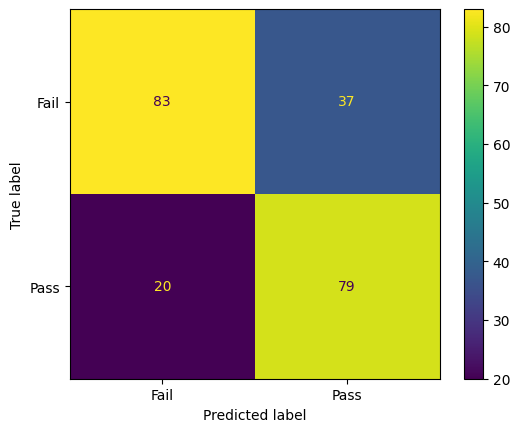

In [22]:
true_pf = true >= 2
predict_pf = predict>=2
cm=confusion_matrix(true_pf, predict_pf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fail','Pass'])
disp.plot()
disp.figure_.savefig(f'{NAME}_pass_fail')
print(f"F1 score {f1_score(true_pf, predict_pf, average='macro')}")
print(f"Accuracy {accuracy_score(true_pf, predict_pf)}")


In [23]:
del model